# 多層パーセプトロン

<img src="ffnn.png">

## 誤差逆伝播法
### ①与えられた入力，重みのまま順伝播させ,出力yを得る．
### ②得られた出力を元に，出力層での重みの勾配を計算．
### ③同様に，l+1層目,l-1層目の情報を用いてl層目の重みの勾配を計算
### ④各層の重みの更新
### ⑤①から④を繰り返す

#### ②について
出力層での重みの勾配は誤差関数を$E_n$,正解データを$\boldsymbol d$とすると
#### $$\begin{align}
\frac{\partial E_n}{\partial \omega_{ji}^{(L)}}&=\frac{\partial E_n}{\partial y}\frac{\partial y}{\partial \omega_{ji}^{(L-1)}}\\
&=(\boldsymbol y(\boldsymbol x)-\boldsymbol d)^T\frac{\partial y}{\partial \omega_{ji}^{(L-1)}}\\
&=(\boldsymbol y(\boldsymbol x)-\boldsymbol d)^T\boldsymbol z_i^{(L-1)}
\end{align}\tag{1}$$
となります．
#### ③について
l層での重みの勾配は，l+1層,l-1層の情報を用いて次のように記述されます．
#### $$\begin{align}
\frac{\partial E_n}{\partial \omega_{ji}^{(l)}}&=\frac{\partial E_n}{\partial u_j^{(l)}}\frac{\partial u_j^{(l)}}{\partial \omega_{ji}^{(L-1)}}\\
&=\bigl(f^{'}(u_j^{(l)})\sum_{k}\omega_{kj}^{(l+1)}(u_k^{(l+1)}-d_k)\bigr)\frac{\partial y}{\partial \omega_{ji}^{(l)}}\\
&=\bigl(f^{'}(u_j^{(l)})\sum_{k}\omega_{kj}^{(l+1)}(u_k^{(l+1)}-d_k)\bigr)\boldsymbol z_i^{(l-1)}
\end{align}\tag{2}$$
#### ④について
重みの更新は以下の式で行います
#### $$\omega^{(l)}:=\omega^{(l)}-\varepsilon \frac{\partial E_n}{\partial \omega^{(l)}}\tag{3}$$

## MNIST

### 必要なライブラリのインポート

In [50]:
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import numpy as np

In [51]:
#
def load_mnist():
    mnist = fetch_mldata('MNIST original')
    mnist_X, mnist_y = shuffle(mnist.data.astype('float32'),
                               mnist.target.astype('int32'), random_state=42)

    mnist_X = mnist_X / 255.0

    return train_test_split(mnist_X, mnist_y,
                test_size=0.2,
                random_state=42)

def validate_homework():
    train_X, test_X, train_y, test_y = load_mnist()

    # validate for small dataset
    train_X_mini = train_X[:100]
    train_y_mini = train_y[:100]
    test_X_mini = test_X[:100]
    test_y_mini = test_y[:100]

    pred_y = homework(train_X_mini, train_y_mini, test_X_mini)
    print(f1_score(test_y_mini, pred_y, average='macro'))

def score_homework():
    train_X, test_X, train_y, test_y = load_mnist()
    pred_y = homework(train_X, train_y, test_X)
    print(f1_score(test_y, pred_y, average='macro'))

In [34]:
#MNISTを分類するクラス
#適切に編集してください

class MLP_MNIST(object):
        def __init__(self):
            pass
        
        def fit(self,x,t):
            

            self.numInput = x.shape[1]  #入力次元
            self.numHidden = 200  #隠れ層次元
            self.numOutput = 10 #出力層次元
            
            # 入力層-隠れ層間の重み初期値
            self.W1 = np.random.uniform(low=-0.08, high=0.08, size=(self.numInput, self.numHidden)).astype('float32')  
            self.b1 = np.zeros(self.numHidden).astype('float32')

            # 隠れ層-出力層間の重み初期値
            self.W2 = np.random.uniform(low=-0.08, high=0.08, size=(self.numHidden, self.numOutput)).astype('float32')
            self.b2 = np.zeros(self.numOutput).astype('float32')
            
            #one-hotベクトルに変換
            t= self.onehot(t)
            
            
            """#通常の学習
            #epoch数、学習を行う
            epoch_number=10000
            for epoch in range(epoch_number):
                if epoch%1000==1:
                        print(epoch)
                        print(self.cost)
                self.train(x, t)
            """
            
            #バッチ学習
            epoch_number=25
            batch_size = 10
            n_batches = x.shape[0] // batch_size
            random_state=42
            
            for epoch in range(epoch_number):
                x, t = shuffle(x, t, random_state=random_state)
                for i in range(n_batches):
                    start = i * batch_size
                    end = start + batch_size
                
                    self.train(x[start:end], t[start:end])
                if epoch%10==1:
                        print("EPOCH",epoch)
                        print("cost",self.cost)
            
            
            
        def train(self, x, t,eps=0.01):
            
            # Forward Propagation Layer1
            u1=np.matmul(x,self.W1)+self.b1
            z1=sigmoid(u1)
            # Forward Propagation Layer2
            u2=np.matmul(z1,self.W2)+self.b2
            y = softmax(u2)
        
            # 誤差（Cross Entropy）
            self.cost =  -np.mean(np.sum(t*np.log(y)))
            
            
            #Back Propagation
            
            #deltaの計算
            delta_2 = y - t # Layer2 delta
            delta_1 = deriv_sigmoid(u1) * np.matmul(delta_2, self.W2.T) # Layer1 delta
            
            #誤差を各重みで偏微分
            dW1 = np.matmul(x.T, delta_1)
            db1 = np.matmul(np.ones(len(x)), delta_1)        

            dW2 = np.matmul(z1.T, delta_2)
            db2 = np.matmul(np.ones(len(z1)), delta_2)
            
            # 重みの更新
            self.W1 = self.W1 - eps*dW1
            self.b1 = self.b1 - eps*db1
           
            self.W2 = self.W2 - eps*dW2
            self.b2 = self.b2 - eps*db2      
              
        def predict(self,x):
            
            # Feed Forward Propagtion
            u1=np.matmul(x,self.W1)+self.b1
            z1=sigmoid(u1)
            u2=np.matmul(z1,self.W2)+self.b2
            y = softmax(u2)
            
            return  y.argmax(axis=1)


        def onehot(self,y):
            """train_yをonehotに変換"""
            Z = np.zeros((len(y), self.numOutput))
            Z[np.arange(len(y)), y] = 1
            return Z
        
def sigmoid(x):
        return 1/(1 + np.exp(-x))
def deriv_sigmoid(x):
        return sigmoid(x)*(1 - sigmoid(x))
def softmax(x):
        exp_x = np.exp(x)
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
def deriv_softmax(x):
        return softmax(x)*(1 - softmax(x))

In [35]:
def homework(train_X, train_y, test_X):
    model = MLP_MNIST()
    model.fit(train_X,train_y)
    ans=model.predict(test_X)
    return ans 

In [36]:
validate_homework()
#score_homework()

OSError: could not read bytes

## $f(x)=x+0.3\sin(2\pi x)$ に沿って生成したノイズを含むデータ点から，近似曲線を推定する

<img src="neuron.png">

### 必要なライブラリのインポート 

In [71]:
import pylab as plt
import numpy as np

### データの作成

In [72]:
def create_toy_dataset(func, n=100):
    #サイズ(n,1)の配列に0~1の乱数を格納
    x = np.random.uniform(size=(n, 1))
    #関数の返り値にノイズを発生
    t = func(x) + np.random.uniform(-0.1, 0.1, size=(n, 1))
    return x, t

#f(x)=x+0.3sin(2πx)を定義
def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

### 多層パーセプトロンによる回帰

In [67]:
#回帰を行うクラス
#適切に編集してください

class MLP_regression(object):
    def __init__(self):
        pass
        
    def fit(self,x,t):
        self.numInput = x.shape[1]  #入力次元
        self.numHidden = 3  #隠れ層次元
        self.numOutput = 1 #出力層次元
            
        # 入力層-隠れ層間の重み初期値
        self.W1 = np.random.uniform(low=-2, high=2, size=(self.numInput, self.numHidden)).astype('float32')  
        self.b1 = np.ones(self.numHidden) * 0.5
        
        # 隠れ層-出力層間の重み初期値
        self.W2 = np.random.uniform(low=-2, high=2, size=(self.numHidden, self.numOutput)).astype('float32')
        self.b2 = np.ones(self.numOutput) * 0.5
        
        #通常の学習
        #epoch数、学習を行う
        epoch_number=100000
        for epoch in range(epoch_number):
            if epoch%10000==1:
                    print("EPOCH",epoch)
                    print("cost",self.cost)
            self.train(x, t)
            
    def train(self, x, t,eps=0.001):
            
            # Forward Propagation Layer1
            u1=np.matmul(x,self.W1)+self.b1
            z1=tanh(u1)
            # Forward Propagation Layer2
            u2=np.matmul(z1,self.W2)+self.b2
            y = u2
        
            # 誤差（二乗誤差）
            self.cost =  0.5 * np.sum((y-t) ** 2)
           
            #Back Propagation
            #deltaの計算
            delta_2 = y - t # Layer2 delta
            delta_1 = deriv_tanh(u1) * np.matmul(delta_2, self.W2.T) # Layer1 delta
            
            #誤差を各重みで偏微分式(1)(2)
            dW1 = np.matmul(x.T, delta_1)
            db1 = np.matmul(np.ones(len(x)), delta_1)        
            dW2 = np.matmul(z1.T, delta_2)
            db2 = np.matmul(np.ones(len(z1)), delta_2)
        
            # 重みの更新式(3)
            self.W1 = self.W1 - eps*dW1
            self.b1 = self.b1 - eps*db1
            self.W2 = self.W2 - eps*dW2
            self.b2 = self.b2 - eps*db2 
        
        
    def predict(self,x):
        # Forward Propagation Layer1
        u1=np.matmul(x,self.W1)+self.b1
        z1=tanh(u1)
        # Forward Propagation Layer2
        u2=np.matmul(z1,self.W2)+self.b2
        y = u2
        return y


### 諸関数の定義

In [73]:
def sigmoid(x):
        return 1/(1 + np.exp(-x))
def deriv_sigmoid(x):
        return sigmoid(x)*(1 - sigmoid(x))
def softmax(x):
        exp_x = np.exp(x)
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
def deriv_softmax(x):
        return softmax(x)*(1 - softmax(x))
def tanh(x):
        return np.tanh(x)
def deriv_tanh(x):
        return 1 - tanh(x) ** 2

### データの学習

In [74]:
#学習データ
x, t = create_toy_dataset(func)

#モデルのインスタンス
model=MLP_regression()

#モデルの学習
model.fit(x,t)

EPOCH 1
cost 57.809903835237755
EPOCH 10001
cost 0.45866105915271727
EPOCH 20001
cost 0.18445237285524851
EPOCH 30001
cost 0.17300294083226586
EPOCH 40001
cost 0.17029680914682846
EPOCH 50001
cost 0.16963178592206957
EPOCH 60001
cost 0.16943561766721638
EPOCH 70001
cost 0.16935107921753298
EPOCH 80001
cost 0.16929695115556487
EPOCH 90001
cost 0.16925417797550893


### データのプロット

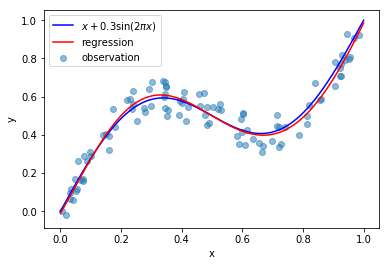

[[ 1.83907941  3.35932043 -2.28138962]]
[-0.89042935 -0.25491622  2.29868813]
[[-1.88462132]
 [ 1.38068538]
 [-2.08977161]]
[1.03959438]


In [70]:
plt.scatter(x, t, alpha=0.5, label="observation")
x_test = np.linspace(0, 1, 1000)[:, np.newaxis]
y = model.predict(x_test)
plt.plot(x_test, func(x_test), color="blue", label="$x+0.3\sin(2\pi x)$")
plt.plot(x_test, y, color="red", label="regression")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
print(model.W1)
print(model.b1)
print(model.W2)
print(model.b2)

## 二値分類

In [42]:
def create_toy_dataset2():
    x = np.random.uniform(-1., 1., size=(1000, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)



(1000, 2)
(1000, 1)


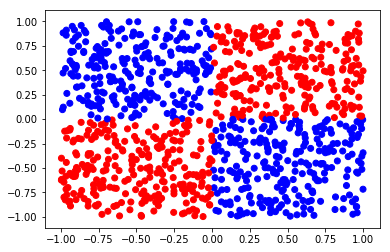

In [45]:
x, labels = create_toy_dataset2()
print(x.shape)
print(labels.shape)
colors = ["blue", "red"]
plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])
plt.show()

In [46]:
class MLP_binary(object):
    def __init__(self):
        pass
    
    def fit(self,x,t):
        self.numInput = x.shape[1]  #入力次元
        self.numHidden = 4  #隠れ層次元
        self.numOutput = 1 #出力層次元
            
        # 入力層-隠れ層間の重み初期値
        self.W1 = np.random.uniform(low=-2, high=2, size=(self.numInput, self.numHidden)).astype('float32')  
        self.b1 = np.ones(self.numHidden) * 0.5
        
        # 隠れ層-出力層間の重み初期値
        self.W2 = np.random.uniform(low=-2, high=2, size=(self.numHidden, self.numOutput)).astype('float32')
        self.b2 = np.ones(self.numOutput) * 0.5
        
        #通常の学習
        #epoch数、学習を行う
        epoch_number=1000
        for epoch in range(epoch_number):
            if epoch%1000==1:
                    print("EPOCH",epoch)
                    print("cost",self.cost)
            self.train(x, t)
            
    def train(self, x, t,eps=0.001):

            # Forward Propagation Layer1
            u1=np.matmul(x,self.W1)+self.b1
            z1=tanh(u1)
            # Forward Propagation Layer2
            u2=np.matmul(z1,self.W2)+self.b2
            y = sigmoid(u2)
        
            
            # 誤差（二乗誤差）
            self.cost =  np.sum(-t * np.log(y) - (1 - t) * np.log(1 - y))
           
            #Back Propagation
            #deltaの計算
            delta_2 = y - t # Layer2 delta

            delta_1 = deriv_tanh(u1) * np.matmul(delta_2, self.W2.T) # Layer1 delta

            
            
            #誤差を各重みで偏微分
            dW1 = np.matmul(x.T, delta_1)
            db1 = np.matmul(np.ones(len(x)), delta_1)        
            dW2 = np.matmul(z1.T, delta_2)
            db2 = np.matmul(np.ones(len(z1)), delta_2)
        
            # 重みの更新
            self.W1 = self.W1 - eps*dW1
            self.b1 = self.b1 - eps*db1
            self.W2 = self.W2 - eps*dW2
            self.b2 = self.b2 - eps*db2 
        
        
    def predict(self,x):
        # Forward Propagation Layer1
        u1=np.matmul(x,self.W1)+self.b1
        z1=tanh(u1)
        # Forward Propagation Layer2
        u2=np.matmul(z1,self.W2)+self.b2
        y = sigmoid(u2)
        return y
    
def sigmoid(x):
        return 1/(1 + np.exp(-x))
def deriv_sigmoid(x):
        return sigmoid(x)*(1 - sigmoid(x))
def softmax(x):
        exp_x = np.exp(x)
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
def deriv_softmax(x):
        return softmax(x)*(1 - softmax(x))
def tanh(x):
        return np.tanh(x)
def deriv_tanh(x):
        return 1 - tanh(x) ** 2

In [47]:
model=MLP_binary()
model.fit(x,labels)



EPOCH 1
cost 1214.5988066127318


In [48]:
X_test, Y_test = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)

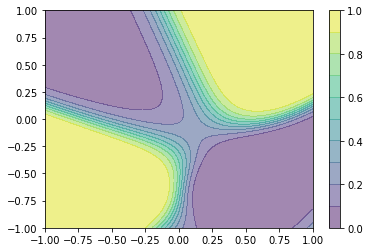

In [49]:
probs = model.predict(x_test)
Probs = probs.reshape(100, 100)
levels = np.linspace(0, 1, 11)
plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()